In [1]:
import time
import yaml
import torch
import logging
import pickle
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np
import seaborn as sns
import torch.nn.functional as F
import seaborn as sns

from tqdm.notebook import tqdm
from torch.optim import Adam, Optimizer
from collections import defaultdict
from torch_geometric.data import Data, InMemoryDataset

from model import APGCN
from seeds import test_seeds, gen_seeds, quick_seeds
from data import get_dataset, set_train_val_test_split

In [2]:
def save_obj(obj, name):
    with open('results/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('results/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def summary(results):
    report={}
    for k, v in results.items():
        if k != 'steps' and k != 'probs':
            boots_series = sns.algorithms.bootstrap(results[k], func=np.mean, n_boot=1000)
            report[k] = np.mean(results[k])
            report[f'{k}_ci'] = np.max(np.abs(sns.utils.ci(boots_series, 95) - report[k]))
        else:
            array = np.array([k.mean().cpu().detach().numpy() for k in results['steps']])
            boots_series = sns.algorithms.bootstrap(array, func=np.mean, n_boot=1000)
            report[k] = np.mean(array)
            report[f'{k}_ci'] = np.max(np.abs(sns.utils.ci(boots_series, 95) - report[k]))
    return report

def plot_density(results):
    fig, ax = plt.subplots()

    z =[(x.cpu().numpy()).astype(int) for x in results['steps']]
    z = np.vstack(z)
    z = np.mean(z,axis=0)

    sns.distplot(z, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                 ax=ax)
    plt.xlabel('Number of Steps')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()
    return

In [3]:
def train(model: torch.nn.Module, optimizer: Optimizer, data: Data, train_halt, weight_decay: float):
    model.train()
    
    for param in model.prop.parameters():
        param.requires_grad = train_halt

    optimizer.zero_grad()
    logits, steps, reminders = model(data)
    
    loss = F.nll_loss(logits[data.train_mask], data.y[data.train_mask])
    l2_reg = sum((torch.sum(param ** 2) for param in model.reg_params))
    loss += weight_decay/2 * l2_reg + model.prop_penalty *(
            steps[data.train_mask] + reminders[data.train_mask]).mean()
    
    loss.backward()
    optimizer.step()
    return

def evaluate(model: torch.nn.Module, data: Data, test: bool, weight_decay: float):
    model.eval()
    
    with torch.no_grad():
        logits, steps, reminders = model(data)
        
        loss = F.nll_loss(logits[data.train_mask], data.y[data.train_mask])
        l2_reg = sum((torch.sum(param ** 2) for param in model.reg_params))
        loss += weight_decay/2 * l2_reg + model.prop_penalty *(
                steps[data.train_mask] + reminders[data.train_mask]).mean()

    eval_dict = {}
    keys = ['train','val']
    eval_dict['steps'] = steps
    for key in keys:
        mask = data[f'{key}_mask']
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        eval_dict[f'{key}_acc'] = acc
    return eval_dict, loss


def test_acc(model: torch.nn.Module, data: Data):
    model.eval()
    
    with torch.no_grad():
        logits, steps, reminders = model(data)
    mask = data['test_mask']
    pred = logits[mask].max(1)[1]
    acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    return acc

In [4]:
def run(dataset: InMemoryDataset,
        model: torch.nn.Module,
        seeds: np.ndarray,
        test: bool = False,
        max_epochs: int = 10000,
        patience: int = 100,
        lr: float = 0.01,
        weight_decay: float = 0.01,
        num_development: int = 1500,
        device: str = 'cuda'):
    

    best_dict = defaultdict(list)

    for seed in tqdm(seeds):
        for _ in range(config['niter_per_seed']):
            torch_seed = gen_seeds()
            torch.manual_seed(seed=torch_seed)
            
            dataset.data = set_train_val_test_split(
                seed,
                dataset.data,
                num_development=num_development,
                num_per_class=20
                ).to(device)
            
            model.to(device).reset_parameters()
            optimizer = Adam(model.parameters(),lr=lr)
            
            patience_counter = 0
            best_loss = 999
            tmp_dict = {'val_acc': 0}
            
            start_time = time.perf_counter()
            for epoch in range(1, max_epochs + 1):
                if patience_counter == patience:
                    break

                train(model, optimizer, dataset.data, epoch%5==0, weight_decay)
                eval_dict, loss = evaluate(model, dataset.data, test, weight_decay)
                                
                if(eval_dict['val_acc'] > tmp_dict['val_acc']) or (
                  (eval_dict['val_acc'] == tmp_dict['val_acc']) and loss < best_loss):
                    patience_counter = 0
                    tmp_dict['epoch'] = epoch
                    tmp_dict['runtime'] = time.perf_counter() - start_time
                    
                    for k, v in eval_dict.items():
                        tmp_dict[k] = v

                    best_state = {key: value.cpu() for key, value
                                      in model.state_dict().items()}
                
                else:
                    patience_counter += 1
                    
                if loss < best_loss:
                    best_loss = loss
                    patience_counter = 0
                            
            model.load_state_dict(best_state)
            tmp_dict['test_acc'] = test_acc(model,dataset.data)
            print("Epoch: {:.1f}"" Train: {:.2f}"" Val: {:.2f}"" Test: {:.2f}".format(
                  tmp_dict['epoch'],
                  tmp_dict['train_acc'] * 100,
                  tmp_dict['val_acc'] * 100,
                  tmp_dict['test_acc'] * 100))
                
            for k, v in tmp_dict.items():
                best_dict[k].append(v)

    return dict(best_dict)

In [5]:
device = 'cuda'

if torch.cuda.is_available():
    torch.cuda.synchronize()
#Datasets: 'citeseer', 'cora_ml' 'pubmed' 'ms_academic', 'amazon_electronics_computers', 'amazon_electronics_photo'
#Num Developent: 1500,1500,1500,5000,1500,1500
# weight_decay 0 for Amazon Datasets 8e-03 for the others
config = {'dataset_name': 'amazon_electronics_computers',
          'test': True,
          'use_lcc': True,
          'num_development': 1500,
          'niter_per_seed': 5,
          'hidden_units': 64,
          'lr': 0.01,
          'dropout': 0.5,
          'weight_decay': 0
         }
    
dataset = get_dataset(
    name=config['dataset_name'],
    use_lcc=config['use_lcc']
    )

dataset.data = dataset.data.to(device)

Epoch: 914.0 Train: 99.00 Val: 88.00 Test: 86.74
Epoch: 1759.0 Train: 99.50 Val: 86.80 Test: 85.35
Epoch: 844.0 Train: 99.00 Val: 86.80 Test: 85.57
Epoch: 676.0 Train: 99.50 Val: 86.60 Test: 85.67
Epoch: 475.0 Train: 98.00 Val: 87.20 Test: 85.40
Epoch: 1168.0 Train: 100.00 Val: 84.40 Test: 85.64
Epoch: 1535.0 Train: 100.00 Val: 84.20 Test: 84.82
Epoch: 1142.0 Train: 100.00 Val: 84.80 Test: 85.21
Epoch: 1143.0 Train: 100.00 Val: 84.40 Test: 85.71
Epoch: 1285.0 Train: 100.00 Val: 85.00 Test: 84.99
Epoch: 1574.0 Train: 100.00 Val: 87.00 Test: 86.03
Epoch: 666.0 Train: 99.50 Val: 86.00 Test: 85.33
Epoch: 467.0 Train: 96.00 Val: 86.80 Test: 86.05
Epoch: 1762.0 Train: 100.00 Val: 86.40 Test: 85.89
Epoch: 1558.0 Train: 100.00 Val: 86.40 Test: 85.66
Epoch: 1819.0 Train: 99.50 Val: 85.00 Test: 85.37
Epoch: 1173.0 Train: 99.50 Val: 83.80 Test: 85.73
Epoch: 1126.0 Train: 98.00 Val: 85.40 Test: 85.05
Epoch: 922.0 Train: 98.50 Val: 84.60 Test: 85.93
Epoch: 1170.0 Train: 99.00 Val: 85.60 Test: 86.40

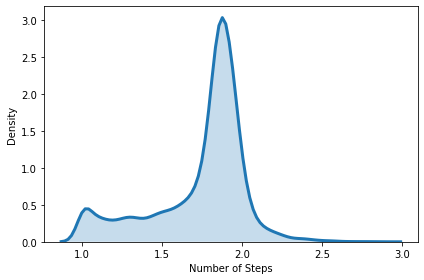

In [6]:
model = APGCN(dataset,10, prop_penalty=0.05)

results = run(
    dataset,
    model,
    seeds=test_seeds if config['test'] else val_seeds,
    #seeds= quick_seeds,
    lr=config['lr'],
    weight_decay=config['weight_decay'],
    test=config['test'],
    num_development=config['num_development'],
    device=device
    )

#save_obj(results,'results_' + config['dataset_name'])
report = summary(results)

print("FINAL\n"
      "Train Accuracy: {:.2f} ± {:.2f}%\n"
      "Stopping Accuracy: {:.2f} ± {:.2f}%\n"
      "Test     Accuracy: {:.2f} ± {:.2f}%\n"
      "Steps: {:.2f} ± {:.2f}\n" 
      "Epochs:  {:.2f} ± {:.2f}\n"
      "Runtime: {:.4f} ± {:.4f}\n"
      .format(
          report['train_acc'] * 100,
          report['train_acc_ci'] * 100,
          report['val_acc'] * 100,
          report['val_acc_ci'] * 100,
          report['test_acc']*100,
          report['test_acc_ci']*100,
          report['steps'],
          report['steps_ci'],
          report['epoch'],
          report['epoch_ci'],
          report['runtime'],
          report['runtime_ci']))

plot_density(results)

del model, dataset
torch.cuda.empty_cache()